# Unsupervised Domain Adaptation for GAMA

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from adapt.instance_based import KLIEP

### Load files

In [2]:
datasets_path = "datasets/"

flux_filename_simbaz0 = datasets_path+'simba_z=0.0_flux.csv'
flux_filename_eaglez0 = datasets_path+'eagle_z=0.0_flux.csv'
flux_filename_tngz0 = datasets_path+'tng_z=0.0_flux.csv'

In [3]:
flux_simbaz0 = pd.read_csv(flux_filename_simbaz0, index_col=0)
flux_eaglez0 = pd.read_csv(flux_filename_eaglez0, index_col=0)
flux_tngz0 = pd.read_csv(flux_filename_tngz0, index_col=0)

dict_X = {"simba": flux_simbaz0, "eagle": flux_eaglez0, "tng": flux_tngz0}

In [4]:
X_base = np.empty((0, dict_X["simba"].shape[1]))
indexes = {}
sub_indexes = {}
length = 0

for k in ["simba", "tng", "eagle"]:
    X_base = np.concatenate((X_base, dict_X[k]))
    indexes[k] = np.arange(len(dict_X[k])) + length
    length += len(dict_X[k])
    print("Domain %s - n_samples : %i"%(k, len(dict_X[k])))
    
print("X shape: %s"%(str(X_base.shape)))

Domain simba - n_samples : 1688
Domain tng - n_samples : 9633
Domain eagle - n_samples : 4697
X shape: (16018, 21)


# Fit KLIEP Weights

In [5]:
TARGET = "eagle"
SOURCES = ["simba", "eagle", "tng"]
SOURCES.remove(TARGET)

print("TARGET = %s\nSOURCES = %s + %s"%(TARGET, SOURCES[0], SOURCES[1]))

TARGET = eagle
SOURCES = simba + tng


## 1. Preprocessing

In [6]:
# Set index for source and target sample
src_index = np.concatenate([indexes[k] for k in SOURCES])
tgt_index = np.concatenate([indexes[k] for k in [TARGET]])

# Rescale X features (first log transformation, then scaling based of source scales)
X = np.log10(X_base+1)
std_sc = StandardScaler()
std_sc.fit(X[src_index])
X = std_sc.transform(X)

In [7]:
def custom_loss(true, pred):
    loss = K.dot(K.square(tf.cast(true, "float32") - pred),
                 tf.cast(tf.identity(kpca.lambdas_.reshape(-1, 1)), "float32"))
    return tf.reduce_mean(loss)


def get_base_model_pca():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(kpca_nb_components, activation=None))
    model.compile(optimizer=Adam(lr_scale), loss=custom_loss)
    return model


def get_base_model_sum():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=None))
    model.compile(optimizer=Adam(lr_kpca), loss="mse")
    return model


def get_encoder():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    return model


def get_task_sum():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=None))
    return model


def get_task_pca():
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(200, activation="relu"))
    model.add(Dense(kpca_nb_components, activation=None))
    return model


def get_discriminator(activation="sigmoid"):
    model = Sequential()
    model.add(Dense(200, activation="relu"))
    model.add(Dense(1, activation=activation))
    return model

## 2. Fit weights

The Parameter ``sigmas`` from ``KLIEP`` control the bandwith of the KLIEP kernels. You can modify it to see the change in the weighting map.

In [8]:
kliep = KLIEP(sigmas=0.5, random_state=0)
kliep_weights = kliep.fit_weights(X[src_index], X[tgt_index])

## 3. Visualize KLIEP weighting map

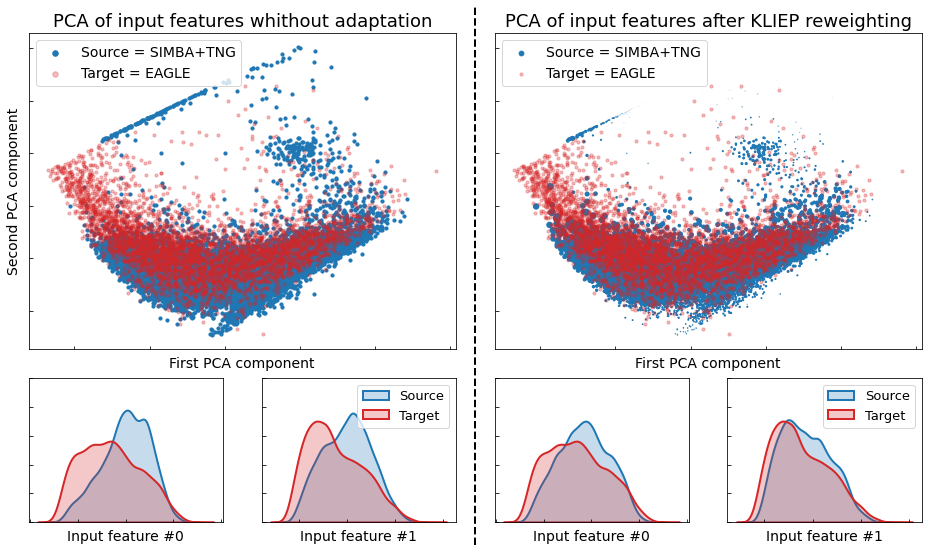

In [9]:
fig = plt.figure(constrained_layout=False, figsize=(16, 9))
gs = fig.add_gridspec(3, 4)

ax1 = fig.add_subplot(gs[0:2, 0:2]); ax2 = fig.add_subplot(gs[0:2, 2:4]);
axes = [fig.add_subplot(gs[2, i]) for i in range(4)]

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

pca = PCA(2)
X_pca = pca.fit_transform(X)
ax1.scatter(x=X_pca[src_index, 0], y=X_pca[src_index, 1], s=10, label="Source = SIMBA+TNG")
ax1.scatter(x=X_pca[tgt_index, 0], y=X_pca[tgt_index, 1], alpha=0.3, s=10, c="C3", label="Target = EAGLE")
ax2.scatter(x=X_pca[src_index, 0], y=X_pca[src_index, 1], s=kliep_weights*10, label="Source = SIMBA+TNG")
ax2.scatter(x=X_pca[tgt_index, 0], y=X_pca[tgt_index, 1], alpha=0.3, s=10, c="C3", label="Target = EAGLE")

ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.tick_params(direction ='in')

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(direction ='in')

lgd1 = ax1.legend(fontsize=14); lgd2 = ax2.legend(fontsize=14);

ax1.set_title("PCA of input features whithout adaptation", fontsize=18)
ax2.set_title("PCA of input features after KLIEP reweighting", fontsize=18)

ax1.set_xlabel("First PCA component", fontsize=14)
ax2.set_xlabel("First PCA component", fontsize=14)
ax1.set_ylabel("Second PCA component", fontsize=14)
# ax2.set_ylabel("Second PCA component", fontsize=14)

lgd1.legendHandles[0].set_sizes([30])
lgd1.legendHandles[1].set_sizes([30])

for i in range(4):
    ax = axes[i]
    if i<2:
        sns.kdeplot(X[src_index, i+1], shade=True, lw=2, ax=ax, label="Source")
        sns.kdeplot(X[tgt_index, i+1], shade=True, lw=2, color="C3", ax=ax, label="Target")
    else:
        sns.kdeplot(X[src_index, i%2+1], shade=True, lw=2, weights=kliep_weights, ax=ax, label="Source")
        sns.kdeplot(X[tgt_index, i%2+1], shade=True, lw=2, color="C3", ax=ax, label="Target")
    
    ax.set_xlabel("Input feature #%i"%(i%2), fontsize=14)
    
    if i in [1, 3]:
        ax.legend(fontsize=13)
    ax.set_ylim(0, 0.5)
    ax.set_ylabel("")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(direction ='in')

line = plt.Line2D([0.512,0.512],[0.09,0.92], linewidth=2.,linestyle="--", transform=fig.transFigure, color="black")
fig.add_artist(line)
plt.show()